In [1]:
"""
The intent of this notebook is model selection and 
evaluation for the MVP of our brainNN classifier.
"""
import sys
import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tornado import gen
from tornado.ioloop import IOLoop
import aimetrics as aim
import aimetrics.metrics as aim_metrics
import seaborn as sns
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
optimal_model_key = '1x4x0.7'
optimal_layers = 1
optimal_cols = 4
optimal_rate = 0.7
X_trn_val = pd.read_csv('output/bnn-mvp/X_trn_val.csv', index_col=0)
y_trn_val = pd.read_csv('output/bnn-mvp/y_trn_val.csv', index_col=0)
X_test = pd.read_csv('output/bnn-mvp/X_test.csv', index_col=0)
y_test = pd.read_csv('output/bnn-mvp/y_test.csv', index_col=0)
with open('output/bnn-mvp/param_metrics.json', 'r') as f:
    val_metrics = json.load(f)[optimal_model_key]
labels = ['small_drone', 'person']
# create data storage variable


In [14]:
from scipy import interp
sns.set()
sns.set_palette(sns.color_palette('muted'))
def plot_roc(label, figsize=(16,16), metrics=val_metrics):
    # This is taken from a skl example:
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    f = plt.figure(figsize=figsize)
    if isinstance(metrics, list):
        for i, fold in enumerate(metrics):
            fold = fold['roc'][label]
            fpr, tpr, thresholds = fold['fpr'], fold['tpr'], fold['threshold']
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        mean_tpr /= len(metrics)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, 'k--',
                 label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    else:
        fold = metrics['roc'][label]
        fpr, tpr, thresholds = fold['fpr'], fold['tpr'], fold['threshold']
        roc_auc = auc(fpr, tpr)
        plt.plot(fold['fpr'], fold['tpr'], label='ROC (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')



    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s Validation ROC' % label)
    plt.legend(loc="lower right")
    plt.show()

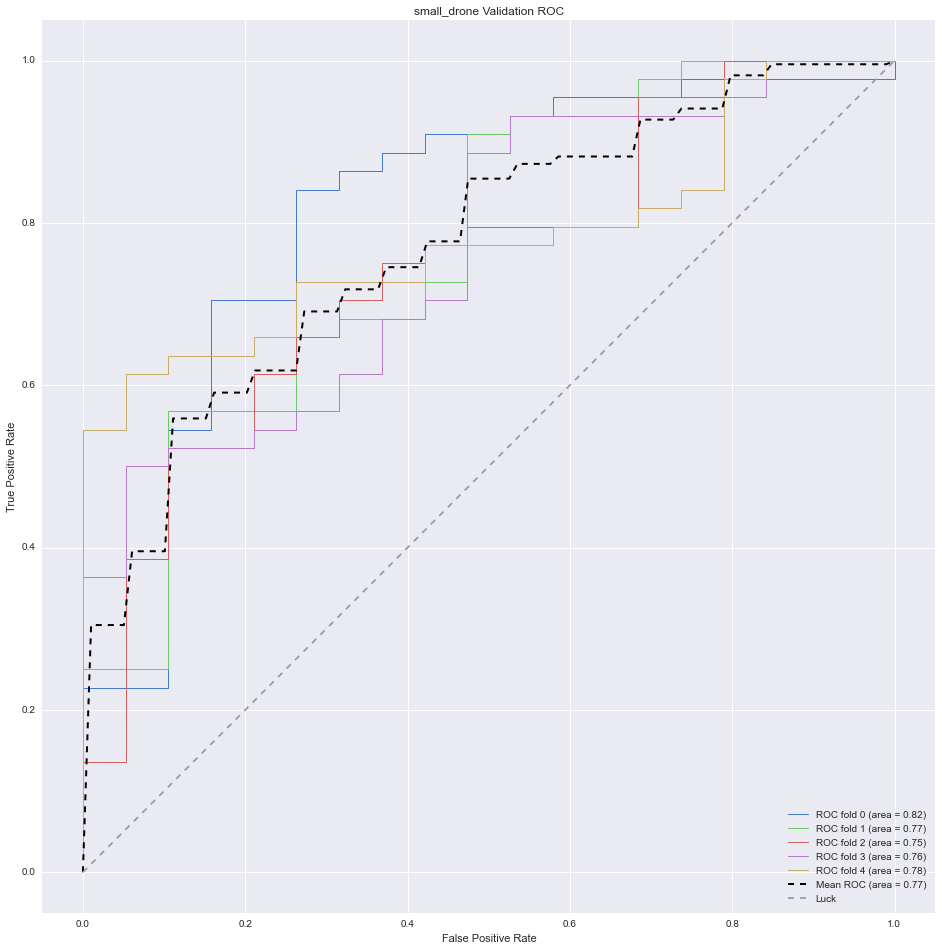

In [15]:
plot_roc('small_drone', metrics=val_metrics)

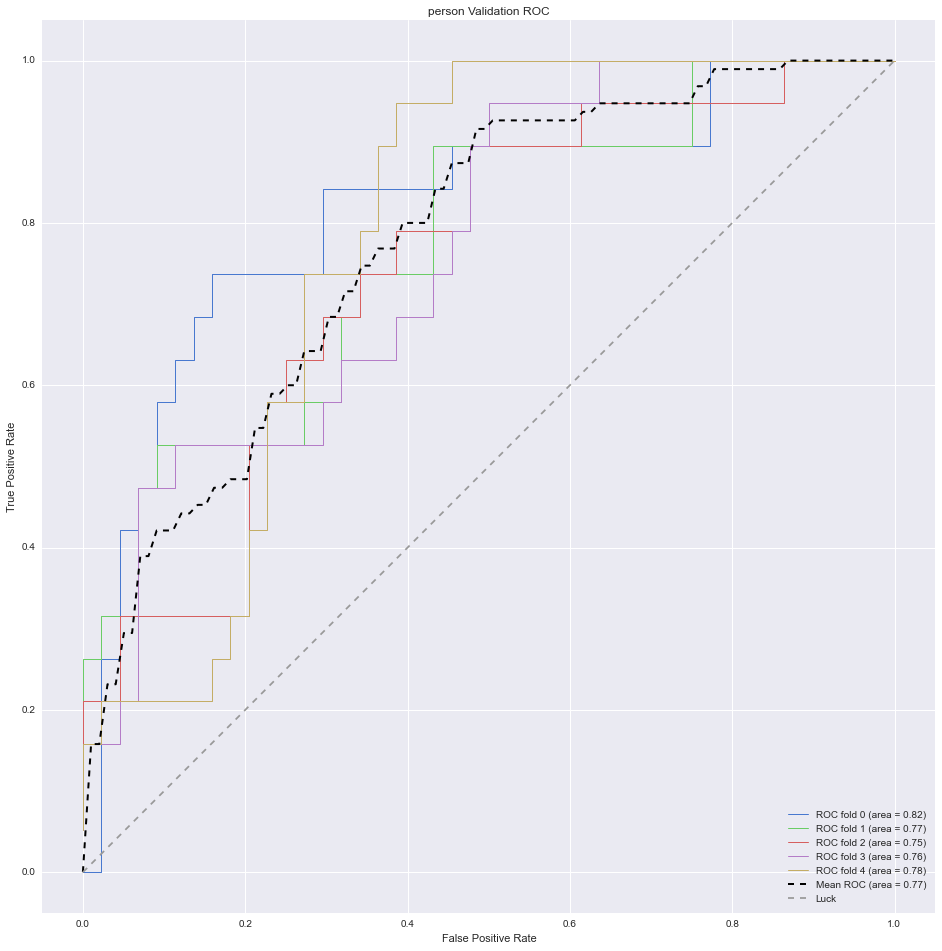

In [16]:
plot_roc('person', metrics=val_metrics)

In [13]:
# train a new classifier using all of of the trn_val set
test_metrics = {}

@gen.coroutine
def get_test_metrics():
    test_metrics = yield aim_metrics.remote_classifier_metrics(
        'http://localhost:3002/', 
        'bnn',
        X_trn_val.values, 
        y_trn_val.values,
        X_test.values,
        y_test.values,
        labels,
        
        
    )
    with open("../output/bnn-mvp/test_metrics.json", 'w') as f:
            json.dump(test_metrics, f)
IOLoop.instance().add_callback(get_test_metrics)